In [1]:
% matplotlib inline
print("Hello, HW 03!")

Hello, HW 03!


In [7]:
def unique_vals(df: pd.DataFrame, col_name: str):
    """Find the unique values for a column in a dataset."""
    uniq, counts = np.unique(df[col_name], return_counts=True)
    return uniq, counts


def class_counts(df: pd.DataFrame):
    """Counts the number of each type of example in a dataset."""
    uniq, counts = unique_vals(df, 'label')
    # dct = {}
    # for i in range(uniq.shape[0]):
    #     dct[uniq[i]] = counts[i]

    return uniq, counts

In [8]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a column name  and an a value for treshhold. 
    The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question.
    """

    def __init__(self, column_name: str, value: float):
        self.column_name = column_name
        self.value = value

    def match(self, row: pd.DataFrame):
        # Compare the feature value in an example to the
        # feature value in this question.
        # TODO FIX ME FOR WORK FOR THE WHOLE COLUMN
        assert len(row.shape) == 1

        val = row[self.column_name]
        return val >= self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        return "Is \'{}\' >= {}?".format(self.column_name, self.value)

In [9]:
def partition(df: pd.DataFrame, question: Question):
    """Partitions a dataset.
    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """

    true_df = df.loc[df[question.column_name] >= question.value]
    false_df = df.loc[df[question.column_name] < question.value]

    return true_df, false_df


In [10]:
from types import *

def gini(df: pd.DataFrame):
    """Calculate the Gini Impurity for a list of rows.
    2nd metrica for IG
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """

    _, counts = class_counts(df)
    return 1 - ((counts / float(len(df))) ** 2).sum()


def entropy(df: pd.DataFrame):
    """1st metrica for IG"""
    from scipy.stats import entropy
    _, counts = class_counts(df)
    probabilities = counts / len(df)
    return entropy(probabilities)


def info_gain(current_uncertainty: float, parent: pd.DataFrame,
              left: pd.DataFrame, right: pd.DataFrame,
              metrica: FunctionType):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.

    Metrica may be gini impurity or entropy
    """
    assert len(parent) == len(left) + len(right)

    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * metrica(left) - (1 - p) * metrica(right)

In [11]:
def find_best_split(df: pd.DataFrame, metrica: FunctionType,
                    custom_features: np.ndarray = None):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""

    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it

    current_uncertainty = metrica(df)
    
    if custom_features is not None:
        features = custom_features
    else:
        features = list(df)[:-1]

#     print("len of feature = {}".format(len(features)))
    for feature in features:  # for each feature
        uniq_values, count = unique_vals(df, feature)

        for val in uniq_values:  # for each value

            question = Question(feature, val)

            # try splitting the dataset
            true_rows, false_rows = partition(df, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(current_uncertainty, df, true_rows, false_rows,
                             metrica)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [12]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows: pd.DataFrame):
        uniq, counts = class_counts(rows)
        self.uniq = uniq
        self.counts = counts

In [13]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self, question: Question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

## Задание 5
Реализуйте алгоритм Random Forest для любого типа критерия (информационный
выигрыш или Джини) с выбором класса по сумме вероятностей. Постройте Precision-recall
и ROC кривую для полученной вероятности на тестовой выборке

In [19]:
def build_tree_for_forest(rows: pd.DataFrame,
                          metrica: FunctionType,
                          max_depth: int,
                          size_of_feature_sample_for_node: int,
                          all_features: list):
    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    if max_depth == 0:
        return Leaf(rows)

    # get random features
    custom_features = random.sample(all_features, size_of_feature_sample_for_node)

    gain, question = find_best_split(rows, metrica, custom_features)
    new_depth = max_depth - 1

    # Base case: no further info gain
    epsilon = 1e-9
    if gain < epsilon or max_depth == 0:
        return Leaf(rows)  # recursive

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree_for_forest(true_rows, metrica, new_depth,
                                        size_of_feature_sample_for_node,
                                        all_features)

    # Recursively build the false branch.
    false_branch = build_tree_for_forest(false_rows, metrica, new_depth,
                                         size_of_feature_sample_for_node,
                                         all_features)

    # Return a Question node.
    return Decision_Node(question, true_branch, false_branch)

In [20]:
# generate bags and features for BAG_NUMBER tree

BAGS_NUMBER = 10 # Number of trees
bags = []
N = len(df_train)
# print("N = {}".format(N))
all_features = (list(df_train))[:-1] # remove label !
import math

N_FEATURES = int(math.sqrt(len(all_features)) * 1.5) # Number of features for tree
# print("N_FEATURES = {}".format(N_FEATURES))


for i in range(BAGS_NUMBER):
    import random
    ixes = np.random.randint(N, size=(N))
    bags.append(df_train.loc[ixes])


In [21]:
# generate trees for every trainig bag
def random_forest_gen_gini(args):
    import datetime
    (tree_no, max_depth, bag) = args
    print("random_forest_gen_gini{} started at {}".format(tree_no, datetime.datetime.utcnow()))
    tree = build_tree_for_forest(bag, gini, max_depth, N_FEATURES, all_features)
    print("random_forest_gen_gini tree {} done at {}".format(tree_no, datetime.datetime.utcnow()))
    return tree


forest = None
MAX_DEPTH = 10
arguments = [(tree_no, MAX_DEPTH, bags[tree_no]) for tree_no in
             range(len(bags))]
print(len(arguments))
# import random
# random.sample(all_features, k=5)

10


In [26]:
print("Will create {} trees".format(len(arguments)))
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
    forest = p.map(random_forest_gen_gini, arguments)

print("# done")

Will create 10 trees
random_forest_gen_gini0 started at 2018-04-12 01:19:46.574968
random_forest_gen_gini1 started at 2018-04-12 01:19:46.580590
random_forest_gen_gini2 started at 2018-04-12 01:19:46.585080
random_forest_gen_gini3 started at 2018-04-12 01:19:46.593863
random_forest_gen_gini5 started at 2018-04-12 01:19:46.613849
random_forest_gen_gini4 started at 2018-04-12 01:19:46.603750
random_forest_gen_gini7 started at 2018-04-12 01:19:46.646017
random_forest_gen_gini6 started at 2018-04-12 01:19:46.627379
random_forest_gen_gini tree 7 done at 2018-04-12 01:21:21.942151
random_forest_gen_gini8 started at 2018-04-12 01:21:22.016533
random_forest_gen_gini tree 0 done at 2018-04-12 01:21:32.244413
random_forest_gen_gini9 started at 2018-04-12 01:21:32.285215
random_forest_gen_gini tree 1 done at 2018-04-12 01:21:38.125518
random_forest_gen_gini tree 3 done at 2018-04-12 01:21:42.303525
random_forest_gen_gini tree 5 done at 2018-04-12 01:21:43.235544
random_forest_gen_gini tree 2 done

In [27]:
def evaluate_forest(df: pd.DataFrame, trees: list) -> np.ndarray:
    def classify_for_forest(row: np.ndarray, node) -> float:
        # Base case: we've reached a leaf
        if isinstance(node, Leaf):
            prob = None
            if len(node.counts) == 1:
                return float(node.uniq[0] == 1)  # 1.0 or 0.0
            
#             elif node.counts[0] >= node.counts[1]:
#                 total = node.counts.sum()
#                 prob = node.counts[0] / total
#             else:

            total = node.counts.sum()
            prob = node.counts[1] / total
            return prob

        # Decide whether to follow the true-branch or the false-branch.
        # Compare the feature / value stored in the node,
        # to the example we're considering.
        if node.question.match(row):
            return classify_for_forest(row, node.true_branch)
        else:
            return classify_for_forest(row, node.false_branch)

    def function_wrapper(row: np.ndarray) -> float:
        # redo classification
        sum_prob = 0.0
        for tr in trees:
            sum_prob += classify_for_forest(row, tr)
        return sum_prob / len(trees)

    return df.apply(function_wrapper, axis=1)

In [28]:
# *_list - is list of lists of points
def draw_curves(prec_list: list, rec_list: list,
                fpr_list: list, tpr_list: list):
    # plot all
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    for i in range(len(prec_list)):
        plt.plot(rec_list[i], prec_list[i], label="{}".format(i))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    plt.title('ROC curve', fontsize=10)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    for i in range(len(fpr_list)):
        roc_auc = auc(fpr_list[i], tpr_list[i])
        plt.plot(fpr_list[i], tpr_list[i], label="with auc={}".format(roc_auc))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


def gen_data_for_roc(results: np.ndarray, labels: np.ndarray, steps = 100):
    y = labels == 1
    STEPS = steps

    prec_list = []
    rec_list = []
    tpr_list = []
    fpr_list = []

    step = 1.0 / STEPS
    a = 0.0001
    TP = []
    FP = []
    TN = []
    FN = []

    for i in range(STEPS):
        Rx = (results >= a)
        tp, fp, tn, fn = get_metriks(Rx, y)
        TP.append(tp)
        FP.append(fp)
        TN.append(tn)
        FN.append(fn)

        a += step

    TP = np.asarray(TP)
    FP = np.asarray(FP)
    TN = np.asarray(TN)
    FN = np.asarray(FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    tpr = recall
    fpr = FP / (FP + TN)

    prec_list.append(precision)
    rec_list.append(recall)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    
    return prec_list, rec_list, tpr_list, fpr_list

In [29]:
forest_prob_array = evaluate_forest(df_test, forest)

# np.seterr(divide='ignore', invalid='ignore')
precision, recall, tpr_list, fpr_list = gen_data_for_roc(forest_prob_array, df_test['label'], 10000)

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

Результат для 10 деревьев, максимальная глубина = 10.

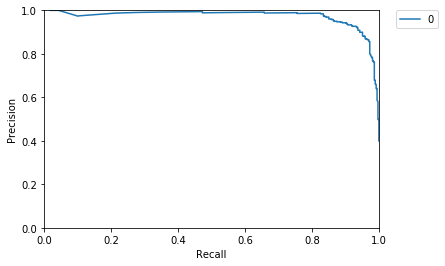

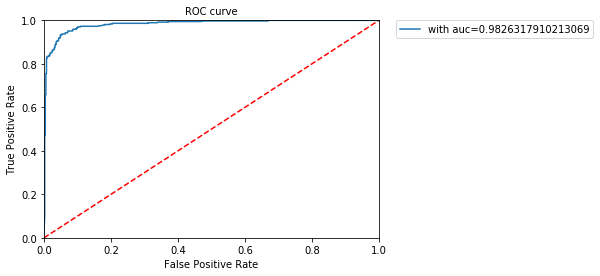

In [30]:
draw_curves(precision, recall, fpr_list, tpr_list)

## Задание 6
Оптимизируйте по AUC на тестовой выборке параметры Random Forest: максимальную
глубину деревьев (в отрезке 2-10), количество деревьев (5, 10, 20, 30, 50, 100, 200, 300). В
этой задаче разумно зафиксировать Random Seed. Постройте Precision-recall и ROC кривую
для лучшего варианта.

Сгенерируем по 50 деревьев на каждую глубину (то есть 400 деревьев в сумме).
Двух часов должно хватить.


In [35]:
# generate bags and features for BAG_NUMBER trees

TREES_NUM = 50
DEPTH_NUMBER = 9
BAGS_NUMBER = TREES_NUM * DEPTH_NUMBER # Number of trees
bags = []
N = len(df_train)
# print("N = {}".format(N))
all_features = (list(df_train))[:-1] # remove label !
import math

# Number of features for tree - set of random features for every node
N_FEATURES = int(math.sqrt(len(all_features)) * 1.2) 
# print("N_FEATURES = {}".format(N_FEATURES))


for i in range(BAGS_NUMBER):
    import random
    ixes = np.random.randint(N, size=(N))
    bags.append(df_train.loc[ixes])


In [36]:
big_forests = {} # { (max_depth, tree)}
arguments = [] # list of lists

for max_depth in range(2,11):
    bag_begin_with_ix = (max_depth - 2) * TREES_NUM
    arguments.append([(tree_no, max_depth, bags[bag_begin_with_ix + tree_no]) for tree_no in range(TREES_NUM)])

In [37]:
max_depth = 2 # start max depth
for args_per_length in arguments:
    print("=================\nWill create {} trees with MAX_DEPTH = {}".format(len(args_per_length), max_depth))
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
        big_forests[max_depth] = p.map(random_forest_gen_gini, args_per_length)

    print("# done with max_depth = {}\n=======================\n".format(max_depth))
    max_depth += 1


Will create 50 trees with MAX_DEPTH = 2
random_forest_gen_gini0 started at 2018-04-12 01:34:20.303532
random_forest_gen_gini2 started at 2018-04-12 01:34:20.318026
random_forest_gen_gini4 started at 2018-04-12 01:34:20.340918
random_forest_gen_gini6 started at 2018-04-12 01:34:20.354337
random_forest_gen_gini8 started at 2018-04-12 01:34:20.372790
random_forest_gen_gini10 started at 2018-04-12 01:34:20.389726
random_forest_gen_gini12 started at 2018-04-12 01:34:20.416589
random_forest_gen_gini14 started at 2018-04-12 01:34:20.436248
random_forest_gen_gini tree 8 done at 2018-04-12 01:34:35.751221
random_forest_gen_gini9 started at 2018-04-12 01:34:35.753363
random_forest_gen_gini tree 14 done at 2018-04-12 01:34:37.485082
random_forest_gen_gini15 started at 2018-04-12 01:34:37.487527
random_forest_gen_gini tree 0 done at 2018-04-12 01:34:39.830595
random_forest_gen_gini1 started at 2018-04-12 01:34:39.833181
random_forest_gen_gini tree 12 done at 2018-04-12 01:34:40.455547
random_fores

random_forest_gen_gini tree 13 done at 2018-04-12 01:37:30.755667
random_forest_gen_gini18 started at 2018-04-12 01:37:30.801667
random_forest_gen_gini tree 9 done at 2018-04-12 01:37:32.982107
random_forest_gen_gini20 started at 2018-04-12 01:37:33.035999
random_forest_gen_gini tree 15 done at 2018-04-12 01:37:36.300133
random_forest_gen_gini22 started at 2018-04-12 01:37:36.329886
random_forest_gen_gini tree 1 done at 2018-04-12 01:37:37.949640
random_forest_gen_gini24 started at 2018-04-12 01:37:37.977928
random_forest_gen_gini tree 3 done at 2018-04-12 01:37:38.245971
random_forest_gen_gini26 started at 2018-04-12 01:37:38.315049
random_forest_gen_gini tree 7 done at 2018-04-12 01:37:39.162128
random_forest_gen_gini28 started at 2018-04-12 01:37:39.207753
random_forest_gen_gini tree 5 done at 2018-04-12 01:37:41.185217
random_forest_gen_gini30 started at 2018-04-12 01:37:41.241996
random_forest_gen_gini tree 16 done at 2018-04-12 01:37:54.117409
random_forest_gen_gini17 started at 

random_forest_gen_gini tree 28 done at 2018-04-12 01:41:55.940890
random_forest_gen_gini29 started at 2018-04-12 01:41:55.944470
random_forest_gen_gini tree 30 done at 2018-04-12 01:42:00.065514
random_forest_gen_gini31 started at 2018-04-12 01:42:00.067919
random_forest_gen_gini tree 25 done at 2018-04-12 01:42:14.077109
random_forest_gen_gini32 started at 2018-04-12 01:42:14.105573
random_forest_gen_gini tree 27 done at 2018-04-12 01:42:14.956762
random_forest_gen_gini34 started at 2018-04-12 01:42:14.974508
random_forest_gen_gini tree 21 done at 2018-04-12 01:42:17.298447
random_forest_gen_gini36 started at 2018-04-12 01:42:17.329925
random_forest_gen_gini tree 17 done at 2018-04-12 01:42:17.679134
random_forest_gen_gini38 started at 2018-04-12 01:42:17.702258
random_forest_gen_gini tree 23 done at 2018-04-12 01:42:20.560070
random_forest_gen_gini40 started at 2018-04-12 01:42:20.643926
random_forest_gen_gini tree 19 done at 2018-04-12 01:42:21.173634
random_forest_gen_gini42 starte

random_forest_gen_gini tree 38 done at 2018-04-12 01:47:52.421495
random_forest_gen_gini39 started at 2018-04-12 01:47:52.429079
random_forest_gen_gini tree 40 done at 2018-04-12 01:47:54.686199
random_forest_gen_gini41 started at 2018-04-12 01:47:54.705526
random_forest_gen_gini tree 36 done at 2018-04-12 01:47:55.272799
random_forest_gen_gini37 started at 2018-04-12 01:47:55.275257
random_forest_gen_gini tree 44 done at 2018-04-12 01:48:02.661714
random_forest_gen_gini45 started at 2018-04-12 01:48:02.688182
random_forest_gen_gini tree 46 done at 2018-04-12 01:48:02.958692
random_forest_gen_gini47 started at 2018-04-12 01:48:02.966402
random_forest_gen_gini tree 33 done at 2018-04-12 01:48:32.010065
random_forest_gen_gini48 started at 2018-04-12 01:48:32.029477
random_forest_gen_gini tree 39 done at 2018-04-12 01:48:35.172440
random_forest_gen_gini tree 35 done at 2018-04-12 01:48:35.582812
random_forest_gen_gini tree 37 done at 2018-04-12 01:48:39.088039
random_forest_gen_gini tree 

random_forest_gen_gini4 started at 2018-04-12 01:55:45.178856
random_forest_gen_gini6 started at 2018-04-12 01:55:45.200165
random_forest_gen_gini8 started at 2018-04-12 01:55:45.219758
random_forest_gen_gini10 started at 2018-04-12 01:55:45.241260
random_forest_gen_gini12 started at 2018-04-12 01:55:45.282192
random_forest_gen_gini14 started at 2018-04-12 01:55:45.328288
random_forest_gen_gini tree 4 done at 2018-04-12 01:56:37.208286
random_forest_gen_gini5 started at 2018-04-12 01:56:37.248382
random_forest_gen_gini tree 8 done at 2018-04-12 01:56:44.496988
random_forest_gen_gini9 started at 2018-04-12 01:56:44.502825
random_forest_gen_gini tree 0 done at 2018-04-12 01:56:45.285424
random_forest_gen_gini1 started at 2018-04-12 01:56:45.292487
random_forest_gen_gini tree 6 done at 2018-04-12 01:56:48.493157
random_forest_gen_gini7 started at 2018-04-12 01:56:48.501623
random_forest_gen_gini tree 12 done at 2018-04-12 01:56:50.208535
random_forest_gen_gini13 started at 2018-04-12 01:5

random_forest_gen_gini20 started at 2018-04-12 02:05:21.631778
random_forest_gen_gini tree 11 done at 2018-04-12 02:05:21.654956
random_forest_gen_gini22 started at 2018-04-12 02:05:21.754121
random_forest_gen_gini tree 13 done at 2018-04-12 02:05:24.285656
random_forest_gen_gini tree 15 done at 2018-04-12 02:05:24.307201
random_forest_gen_gini24 started at 2018-04-12 02:05:24.318360
random_forest_gen_gini26 started at 2018-04-12 02:05:24.362582
random_forest_gen_gini tree 1 done at 2018-04-12 02:05:25.042870
random_forest_gen_gini28 started at 2018-04-12 02:05:25.088059
random_forest_gen_gini tree 3 done at 2018-04-12 02:05:34.656887
random_forest_gen_gini30 started at 2018-04-12 02:05:34.741473
random_forest_gen_gini tree 16 done at 2018-04-12 02:06:24.213263
random_forest_gen_gini17 started at 2018-04-12 02:06:24.215510
random_forest_gen_gini tree 20 done at 2018-04-12 02:06:26.478433
random_forest_gen_gini21 started at 2018-04-12 02:06:26.485777
random_forest_gen_gini tree 26 done 

random_forest_gen_gini31 started at 2018-04-12 02:15:41.344252
random_forest_gen_gini tree 21 done at 2018-04-12 02:16:09.258282
random_forest_gen_gini32 started at 2018-04-12 02:16:09.300619
random_forest_gen_gini tree 19 done at 2018-04-12 02:16:09.686584
random_forest_gen_gini34 started at 2018-04-12 02:16:09.748794
random_forest_gen_gini tree 17 done at 2018-04-12 02:16:15.669621
random_forest_gen_gini36 started at 2018-04-12 02:16:15.762248
random_forest_gen_gini tree 23 done at 2018-04-12 02:16:21.922494
random_forest_gen_gini38 started at 2018-04-12 02:16:22.027844
random_forest_gen_gini tree 25 done at 2018-04-12 02:16:27.153633
random_forest_gen_gini40 started at 2018-04-12 02:16:27.225756
random_forest_gen_gini tree 27 done at 2018-04-12 02:16:36.038844
random_forest_gen_gini42 started at 2018-04-12 02:16:36.082137
random_forest_gen_gini tree 29 done at 2018-04-12 02:16:39.136058
random_forest_gen_gini44 started at 2018-04-12 02:16:39.192760
random_forest_gen_gini tree 31 don

random_forest_gen_gini47 started at 2018-04-12 02:27:47.896218
random_forest_gen_gini tree 36 done at 2018-04-12 02:27:48.988705
random_forest_gen_gini37 started at 2018-04-12 02:27:49.008222
random_forest_gen_gini tree 38 done at 2018-04-12 02:27:52.392719
random_forest_gen_gini39 started at 2018-04-12 02:27:52.395193
random_forest_gen_gini tree 44 done at 2018-04-12 02:28:00.733485
random_forest_gen_gini45 started at 2018-04-12 02:28:00.752213
random_forest_gen_gini tree 33 done at 2018-04-12 02:28:56.153832
random_forest_gen_gini48 started at 2018-04-12 02:28:56.195005
random_forest_gen_gini tree 41 done at 2018-04-12 02:28:57.479474
random_forest_gen_gini tree 43 done at 2018-04-12 02:29:05.446319
random_forest_gen_gini tree 35 done at 2018-04-12 02:29:07.490393
random_forest_gen_gini tree 47 done at 2018-04-12 02:29:08.777311
random_forest_gen_gini tree 37 done at 2018-04-12 02:29:09.557060
random_forest_gen_gini tree 39 done at 2018-04-12 02:29:12.219671
random_forest_gen_gini tr

Надо выбрать лучшую пару (depth, number_of_trees) по auc

In [38]:
# count auc for every pair (k, tree), write to array, then find max auc, draw roc curve for this auc
stats = [] # [(maxdepth, number_of_trees, trees, auc)]


# for max_depth, trees in big_forests.items():
def calc_auc_for_trees(args):
    max_depth, num_of_trees = args
    best_auc = 0.0
    res = None
    for i in range(3):
        cur_tree_list = random.sample(big_forests[max_depth], num_of_trees)
        forest_prob_array = evaluate_forest(df_test, cur_tree_list)
        # np.seterr(divide='ignore', invalid='ignore')
        precision, recall, tpr_list, fpr_list = gen_data_for_roc(forest_prob_array, df_test['label'], 100)
        cur_auc = auc(fpr_list[0], tpr_list[0])
        if cur_auc > best_auc:
            res = (max_depth, num_of_trees, cur_tree_list, cur_auc) 
        
#     stats.append( (max_depth, num_of_trees, cur_tree_list, cur_auc) )
    stats.append( res )
    print("done depth = {}, num_of_trees = {}".format(max_depth, num_of_trees))
    return (res)

        
        
arguments = [(max_depth, num_of_trees) for max_depth in range(2,11) for num_of_trees in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]]
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
    stats = p.map(calc_auc_for_trees, arguments)
    
stats

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 2, num_of_trees = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 3, num_of_trees = 5
done depth = 2, num_of_trees = 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 4, num_of_trees = 10
done depth = 2, num_of_trees = 10
done depth = 2, num_of_trees = 20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 3, num_of_trees = 10
done depth = 3, num_of_trees = 25
done depth = 2, num_of_trees = 15
done depth = 2, num_of_trees = 40
done depth = 3, num_of_trees = 15
done depth = 4, num_of_trees = 15
done depth = 2, num_of_trees = 25
done depth = 4, num_of_trees = 30
done depth = 3, num_of_trees = 45
done depth = 3, num_of_trees = 20
done depth = 3, num_of_trees = 30
done depth = 2, num_of_trees = 30
done depth = 4, num_of_trees = 20
done depth = 2, num_of_trees = 45
done depth = 5, num_of_trees = 15
done depth = 2, num_of_trees = 35
done depth = 4, num_of_trees = 50
done depth = 4, num_of_trees = 35
done depth = 5, num_of_trees = 1
done depth = 4, num_of_trees = 25
done depth = 3, num_of_trees = 35
done depth = 6, num_of_trees = 1
done depth = 3, num_of_trees = 50
done depth = 4, num_of_trees = 1
done depth = 2, num_of_trees = 50
done depth = 5, num_of_trees = 5
done depth = 3, num_of_trees = 1
done depth = 6, num_of_trees = 5
done depth = 4, num_of_trees = 5
done depth = 5, num_o

[(2, 1, [<__main__.Decision_Node at 0x7fd378aa9898>], 0.841919569148518),
 (2,
  5,
  0.9342617344130827),
 (2,
  10,
  0.943256643604057),
 (2,
  15,
  0.9679097216762325),
 (2,
  20,
  0.9590696005975313),
 (2,
  25,
  0.9598853093796682),
 (2,
  30,
  0.9656247543045836),
 (2,
  35,
  0.9636985022407422),
 (2,
  40,
  0.9670989268024215),
 (2,
  45,
  0.9662733902036323),
 (2,
  50,
  0.9666886154571901),
 (3, 1, [<__main__.Decision_Node at 0x7fd3765b0f28>], 0.8627668252221086),
 (3,
  5,
  0.9509591949052599),
 (3,
  10,
  0.9617132832769872),
 (3,
  15,
  0.966843403569463),
 (3,
  20,
  0.9663937809576226),
 (3,
  25,
  0.9683224899756271),
 (3,
  30,
  0.9668999135152135),
 (3,
  35,
  0.9673249665854233),
 (3,
  40,
  0.9685141324003459),
 (3,
  45,
  0.9689883245538171),
 (3,
  50,
  0.9693175564116676),
 (4, 1, [<__main__.Decision_Node at 0x7fd37652d320>], 0.7820411392405062),
 (4,
  5,
  0.9596936669549494),
 (4,
  10,
  0.9571261498545482),
 (4,
  15,
  0.9726737557984119),

Max param: max_depth = 10, num_of_trees = 25, auc = 0.9876660901014231 


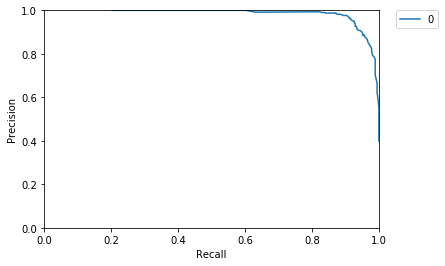

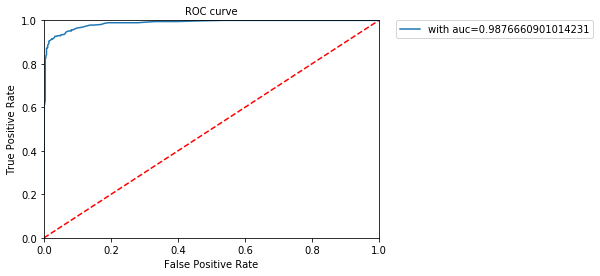

In [39]:
max_depth, num_of_trees, cur_tree_list, cur_aucv = max(stats, key=lambda tpl: tpl[3])
print("Max param: max_depth = {}, num_of_trees = {}, auc = {} ".format(max_depth, num_of_trees, cur_aucv))
forest_prob_array = evaluate_forest(df_test, cur_tree_list)
# np.seterr(divide='ignore', invalid='ignore')
precision, recall, tpr_list, fpr_list = gen_data_for_roc(forest_prob_array, df_test['label'], 100)
draw_curves(precision, recall, fpr_list, tpr_list)

#### Проверим, какие будут отличия, если не делать фичэ беггинг

In [40]:
def build_tree_for_forest_all_features(rows: pd.DataFrame,
                          metrica: FunctionType,
                          max_depth: int,
                          size_of_feature_sample_for_node: int,
                          all_features: list):
    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    if max_depth == 0:
        return Leaf(rows)

    
    custom_features = all_features

    gain, question = find_best_split(rows, metrica, custom_features)
    new_depth = max_depth - 1

    # Base case: no further info gain
    epsilon = 1e-9
    if gain < epsilon or max_depth == 0:
        return Leaf(rows)  # recursive

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree_for_forest(true_rows, metrica, new_depth,
                                        size_of_feature_sample_for_node,
                                        all_features)

    # Recursively build the false branch.
    false_branch = build_tree_for_forest(false_rows, metrica, new_depth,
                                         size_of_feature_sample_for_node,
                                         all_features)

    # Return a Question node.
    return Decision_Node(question, true_branch, false_branch)

# generate trees for every trainig bag
def random_forest_gen_gini2(args):
    import datetime
    (tree_no, max_depth, bag) = args
    print("random_forest_gen_gini{} started at {}".format(tree_no, datetime.datetime.utcnow()))
    tree = build_tree_for_forest_all_features(bag, gini, max_depth, N_FEATURES, all_features)
    print("random_forest_gen_gini tree {} done at {}".format(tree_no, datetime.datetime.utcnow()))
    return tree

In [41]:
big_forests2 = {} # { (max_depth, tree)}
arguments2 = [] # list of lists

for max_depth in range(2,11):
    bag_begin_with_ix = (max_depth - 2) * TREES_NUM
    arguments2.append([(tree_no, max_depth, bags[bag_begin_with_ix + tree_no]) for tree_no in range(TREES_NUM)])

In [42]:
max_depth = 2
for args_per_length in arguments2:
    print("=================\nWill create {} trees with MAX_DEPTH = {}".format(len(args_per_length), max_depth))
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
        big_forests2[max_depth] = p.map(random_forest_gen_gini2, args_per_length)

    print("# done with max_depth = {}\n=======================\n".format(max_depth))
    max_depth += 1
print("DONE DONE")

Will create 50 trees with MAX_DEPTH = 2
random_forest_gen_gini0 started at 2018-04-12 02:35:12.503760
random_forest_gen_gini2 started at 2018-04-12 02:35:12.516854
random_forest_gen_gini4 started at 2018-04-12 02:35:12.531366
random_forest_gen_gini6 started at 2018-04-12 02:35:12.548761
random_forest_gen_gini8 started at 2018-04-12 02:35:12.571310
random_forest_gen_gini10 started at 2018-04-12 02:35:12.595828
random_forest_gen_gini12 started at 2018-04-12 02:35:12.641820
random_forest_gen_gini14 started at 2018-04-12 02:35:12.675942
random_forest_gen_gini tree 14 done at 2018-04-12 02:36:23.972744
random_forest_gen_gini15 started at 2018-04-12 02:36:23.980961
random_forest_gen_gini tree 4 done at 2018-04-12 02:36:24.474038
random_forest_gen_gini5 started at 2018-04-12 02:36:24.482162
random_forest_gen_gini tree 8 done at 2018-04-12 02:36:24.903987
random_forest_gen_gini9 started at 2018-04-12 02:36:24.912338
random_forest_gen_gini tree 6 done at 2018-04-12 02:36:25.725793
random_forest

random_forest_gen_gini tree 13 done at 2018-04-12 02:46:10.873766
random_forest_gen_gini18 started at 2018-04-12 02:46:10.932780
random_forest_gen_gini tree 3 done at 2018-04-12 02:46:11.870979
random_forest_gen_gini20 started at 2018-04-12 02:46:11.894539
random_forest_gen_gini tree 11 done at 2018-04-12 02:46:12.779246
random_forest_gen_gini22 started at 2018-04-12 02:46:12.857591
random_forest_gen_gini tree 9 done at 2018-04-12 02:46:13.823610
random_forest_gen_gini24 started at 2018-04-12 02:46:13.879984
random_forest_gen_gini tree 5 done at 2018-04-12 02:46:16.106763
random_forest_gen_gini26 started at 2018-04-12 02:46:16.180725
random_forest_gen_gini tree 1 done at 2018-04-12 02:46:17.995012
random_forest_gen_gini28 started at 2018-04-12 02:46:18.030830
random_forest_gen_gini tree 15 done at 2018-04-12 02:46:24.086928
random_forest_gen_gini30 started at 2018-04-12 02:46:24.118933
random_forest_gen_gini tree 16 done at 2018-04-12 02:47:27.968431
random_forest_gen_gini17 started at

random_forest_gen_gini tree 28 done at 2018-04-12 02:57:25.238494
random_forest_gen_gini29 started at 2018-04-12 02:57:25.260433
random_forest_gen_gini tree 30 done at 2018-04-12 02:57:30.984842
random_forest_gen_gini31 started at 2018-04-12 02:57:31.012175
random_forest_gen_gini tree 19 done at 2018-04-12 02:58:36.569941
random_forest_gen_gini32 started at 2018-04-12 02:58:36.622221
random_forest_gen_gini tree 17 done at 2018-04-12 02:58:38.257184
random_forest_gen_gini34 started at 2018-04-12 02:58:38.287479
random_forest_gen_gini tree 27 done at 2018-04-12 02:58:41.441006
random_forest_gen_gini36 started at 2018-04-12 02:58:41.486003
random_forest_gen_gini tree 23 done at 2018-04-12 02:58:46.667333
random_forest_gen_gini38 started at 2018-04-12 02:58:46.703086
random_forest_gen_gini tree 21 done at 2018-04-12 02:58:47.606533
random_forest_gen_gini40 started at 2018-04-12 02:58:47.661703
random_forest_gen_gini tree 25 done at 2018-04-12 02:58:49.788961
random_forest_gen_gini42 starte

random_forest_gen_gini tree 40 done at 2018-04-12 03:11:20.378327
random_forest_gen_gini41 started at 2018-04-12 03:11:20.386024
random_forest_gen_gini tree 38 done at 2018-04-12 03:11:25.269498
random_forest_gen_gini39 started at 2018-04-12 03:11:25.292265
random_forest_gen_gini tree 42 done at 2018-04-12 03:11:29.667880
random_forest_gen_gini43 started at 2018-04-12 03:11:29.683752
random_forest_gen_gini tree 44 done at 2018-04-12 03:11:33.640852
random_forest_gen_gini45 started at 2018-04-12 03:11:33.643461
random_forest_gen_gini tree 46 done at 2018-04-12 03:11:35.824262
random_forest_gen_gini47 started at 2018-04-12 03:11:35.846472
random_forest_gen_gini tree 33 done at 2018-04-12 03:12:44.685882
random_forest_gen_gini48 started at 2018-04-12 03:12:44.706757
random_forest_gen_gini tree 37 done at 2018-04-12 03:12:52.943678
random_forest_gen_gini tree 35 done at 2018-04-12 03:12:54.988603
random_forest_gen_gini tree 41 done at 2018-04-12 03:12:55.136194
random_forest_gen_gini tree 

random_forest_gen_gini4 started at 2018-04-12 03:26:48.234877
random_forest_gen_gini6 started at 2018-04-12 03:26:48.252329
random_forest_gen_gini8 started at 2018-04-12 03:26:48.274024
random_forest_gen_gini10 started at 2018-04-12 03:26:48.298989
random_forest_gen_gini12 started at 2018-04-12 03:26:48.318924
random_forest_gen_gini14 started at 2018-04-12 03:26:48.355687
random_forest_gen_gini tree 0 done at 2018-04-12 03:28:40.908288
random_forest_gen_gini1 started at 2018-04-12 03:28:40.927925
random_forest_gen_gini tree 14 done at 2018-04-12 03:28:42.389039
random_forest_gen_gini15 started at 2018-04-12 03:28:42.396415
random_forest_gen_gini tree 4 done at 2018-04-12 03:28:47.818265
random_forest_gen_gini5 started at 2018-04-12 03:28:47.848222
random_forest_gen_gini tree 8 done at 2018-04-12 03:28:50.463346
random_forest_gen_gini9 started at 2018-04-12 03:28:50.492308
random_forest_gen_gini tree 6 done at 2018-04-12 03:28:51.538599
random_forest_gen_gini7 started at 2018-04-12 03:2

random_forest_gen_gini tree 5 done at 2018-04-12 03:44:37.593392
random_forest_gen_gini20 started at 2018-04-12 03:44:37.630326
random_forest_gen_gini tree 3 done at 2018-04-12 03:44:38.235626
random_forest_gen_gini22 started at 2018-04-12 03:44:38.289349
random_forest_gen_gini tree 13 done at 2018-04-12 03:44:42.181352
random_forest_gen_gini24 started at 2018-04-12 03:44:42.220209
random_forest_gen_gini tree 7 done at 2018-04-12 03:44:49.739145
random_forest_gen_gini26 started at 2018-04-12 03:44:49.842485
random_forest_gen_gini tree 15 done at 2018-04-12 03:44:49.990445
random_forest_gen_gini28 started at 2018-04-12 03:44:50.031081
random_forest_gen_gini tree 1 done at 2018-04-12 03:45:11.311652
random_forest_gen_gini30 started at 2018-04-12 03:45:11.417698
random_forest_gen_gini tree 16 done at 2018-04-12 03:46:31.805528
random_forest_gen_gini17 started at 2018-04-12 03:46:31.812750
random_forest_gen_gini tree 20 done at 2018-04-12 03:46:44.920064
random_forest_gen_gini21 started at

random_forest_gen_gini tree 30 done at 2018-04-12 04:02:01.776168
random_forest_gen_gini31 started at 2018-04-12 04:02:01.800498
random_forest_gen_gini tree 23 done at 2018-04-12 04:03:35.676048
random_forest_gen_gini32 started at 2018-04-12 04:03:35.758527
random_forest_gen_gini tree 21 done at 2018-04-12 04:03:37.429190
random_forest_gen_gini34 started at 2018-04-12 04:03:37.516905
random_forest_gen_gini tree 17 done at 2018-04-12 04:03:42.556340
random_forest_gen_gini36 started at 2018-04-12 04:03:42.604500
random_forest_gen_gini tree 19 done at 2018-04-12 04:03:46.765549
random_forest_gen_gini38 started at 2018-04-12 04:03:46.852018
random_forest_gen_gini tree 25 done at 2018-04-12 04:03:56.486740
random_forest_gen_gini40 started at 2018-04-12 04:03:56.631958
random_forest_gen_gini tree 27 done at 2018-04-12 04:04:01.852489
random_forest_gen_gini42 started at 2018-04-12 04:04:01.940951
random_forest_gen_gini tree 31 done at 2018-04-12 04:04:07.611670
random_forest_gen_gini44 starte

random_forest_gen_gini tree 38 done at 2018-04-12 04:21:37.082723
random_forest_gen_gini39 started at 2018-04-12 04:21:37.113628
random_forest_gen_gini tree 46 done at 2018-04-12 04:21:52.789359
random_forest_gen_gini47 started at 2018-04-12 04:21:52.807732
random_forest_gen_gini tree 44 done at 2018-04-12 04:21:52.815724
random_forest_gen_gini45 started at 2018-04-12 04:21:52.837665
random_forest_gen_gini tree 42 done at 2018-04-12 04:21:53.255803
random_forest_gen_gini43 started at 2018-04-12 04:21:53.263591
random_forest_gen_gini tree 33 done at 2018-04-12 04:23:31.936765
random_forest_gen_gini48 started at 2018-04-12 04:23:32.061905
random_forest_gen_gini tree 35 done at 2018-04-12 04:23:35.324485
random_forest_gen_gini tree 39 done at 2018-04-12 04:23:40.863165
random_forest_gen_gini tree 41 done at 2018-04-12 04:23:47.811880
random_forest_gen_gini tree 37 done at 2018-04-12 04:23:50.042370
random_forest_gen_gini tree 43 done at 2018-04-12 04:23:58.261720
random_forest_gen_gini tr

In [43]:
arguments2 = [(max_depth, num_of_trees) for max_depth in range(2,11) for num_of_trees in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]]
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as p:
    stats2 = p.map(calc_auc_for_trees, arguments2)
    
stats2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 2, num_of_trees = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 3, num_of_trees = 5
done depth = 2, num_of_trees = 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 4, num_of_trees = 10
done depth = 2, num_of_trees = 20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done depth = 2, num_of_trees = 10
done depth = 3, num_of_trees = 10
done depth = 3, num_of_trees = 25
done depth = 2, num_of_trees = 15
done depth = 2, num_of_trees = 40
done depth = 2, num_of_trees = 25
done depth = 4, num_of_trees = 15
done depth = 3, num_of_trees = 15
done depth = 4, num_of_trees = 30
done depth = 3, num_of_trees = 45
done depth = 3, num_of_trees = 20
done depth = 3, num_of_trees = 30
done depth = 2, num_of_trees = 30
done depth = 4, num_of_trees = 20
done depth = 2, num_of_trees = 45
done depth = 5, num_of_trees = 15
done depth = 4, num_of_trees = 35
done depth = 2, num_of_trees = 35
done depth = 4, num_of_trees = 50
done depth = 3, num_of_trees = 35
done depth = 5, num_of_trees = 1
done depth = 3, num_of_trees = 50
done depth = 4, num_of_trees = 25
done depth = 4, num_of_trees = 1
done depth = 6, num_of_trees = 1
done depth = 2, num_of_trees = 50
done depth = 5, num_of_trees = 5
done depth = 3, num_of_trees = 1
done depth = 4, num_of_trees = 5
done depth = 6, num_

[(2, 1, [<__main__.Decision_Node at 0x7fd37b33a438>], 0.8054288859187042),
 (2,
  5,
  0.927384719710669),
 (2,
  10,
  0.9564799709096625),
 (2,
  15,
  0.9630080981209215),
 (2,
  20,
  0.9576814214954006),
 (2,
  25,
  0.9653913436590927),
 (2,
  30,
  0.9640154493277773),
 (2,
  35,
  0.9664601187200251),
 (2,
  40,
  0.9663520127368503),
 (2,
  45,
  0.9662119663495558),
 (2,
  50,
  0.9666886154571901),
 (3, 1, [<__main__.Decision_Node at 0x7fd34d26e978>], 0.8895107712870509),
 (3,
  5,
  0.963339786932935),
 (3,
  10,
  0.9606690777576854),
 (3,
  15,
  0.9654281979715387),
 (3,
  20,
  0.9677868739680792),
 (3,
  25,
  0.96777950310559),
 (3,
  30,
  0.9668384896611368),
 (3,
  35,
  0.9693912650365594),
 (3,
  40,
  0.9695730796446261),
 (3,
  45,
  0.9689760397830018),
 (3,
  50,
  0.9693175564116676),
 (4, 1, [<__main__.Decision_Node at 0x7fd34d19f4a8>], 0.6732766923500275),
 (4,
  5,
  0.9628115417878764),
 (4,
  10,
  0.9680718806509945),
 (4,
  15,
  0.9731676035851874),


Max param: max_depth = 10, num_of_trees = 45, auc = 0.9868872356317321 


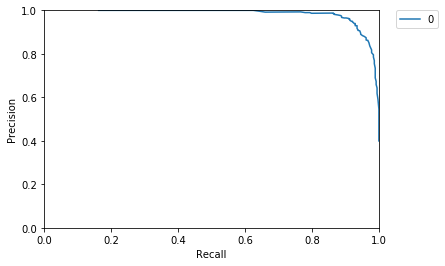

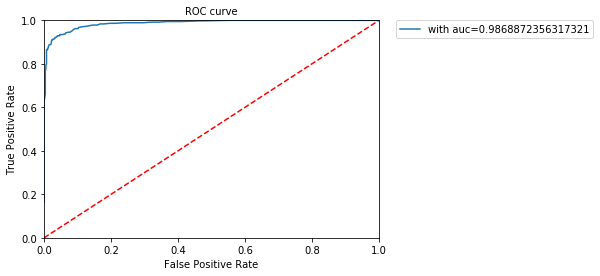

In [44]:
max_depth, num_of_trees, cur_tree_list, cur_aucv = max(stats2, key=lambda tpl: tpl[3])
print("Max param: max_depth = {}, num_of_trees = {}, auc = {} ".format(max_depth, num_of_trees, cur_aucv))
forest_prob_array = evaluate_forest(df_test, cur_tree_list)
# np.seterr(divide='ignore', invalid='ignore')
precision, recall, tpr_list, fpr_list = gen_data_for_roc(forest_prob_array, df_test['label'], 100)
draw_curves(precision, recall, fpr_list, tpr_list)